In [1]:
nmax = 4
labels = ["nPH", "nPN"]
modes = ["bars", "barstri"]
dp = 12

In [2]:
configs = [
    {
        "distance": 15,
        "doubleplane": dp,
        "energy": 600,
        "erel": 500,
        "neutrons": range(1, nmax + 1),
        "subruns": range(6),  # range(19),
        "subrun_cache_size": 6,
        "batch_size": 100,
        "label": label,
        "mode": mode,
        "nmax": nmax,
        "suffix": "bars-scaled.parquet",
    }
    for mode in modes
    for label in labels
]

In [3]:
import gc
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing
from datagenerators import DataGeneratorBars
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

In [4]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [5]:
runs = []
for config in configs:
    nclasses = config["nmax"] + 1
    
    validation_config = config.copy()
    validation_config["subruns"] = [19]
    
    generator = DataGeneratorBars(config)
    validation_generator = DataGeneratorBars(validation_config)

    models = defaultdict(keras.models.Sequential)

    models["(SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
    models["(10, SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
    models["(20, SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
    models["(100, SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
    models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
    models["(100, 10, SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    models["(3000, 50, SM)"].add(keras.layers.Dense(units=3000, activation="relu"))
    models["(3000, 50, SM)"].add(keras.layers.Dense(units=50, activation="relu"))
    models["(3000, 50, SM)"].add(keras.layers.Dense(units=nclasses, activation="softmax"))

    optimizer = keras.optimizers.Adam
    loss = keras.losses.CategoricalCrossentropy

    histories = {}
    for name, model in models.items():
        print(name)
        model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
        histories[name] = model.fit(
            generator, verbose=3, epochs=20, shuffle=False, validation_data=validation_generator
        )
        print("----")

    runs.append({"config": config, "models": models, "histories": histories})

    del generator
    del validation_generator
    gc.collect()

Rows in one file: 10000
400 batches per subrun
2400 total batches in [range(0, 6)] caches
Loading subruns range(0, 6) for cache 0
Rows in one file: 10000
400 batches per subrun
400 total batches in [[19]] caches
Loading subruns [19] for cache 0
(SM)
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
----
(10, SM)
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
----
(20, SM)
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
----
(100, SM)
Epoch 1/20
Epo

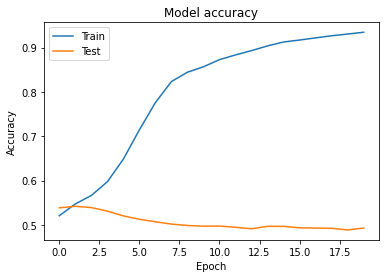

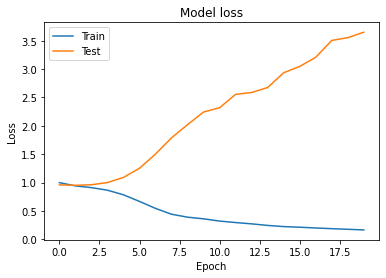

In [6]:
history = runs[3]["histories"]["(3000, 50, SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [7]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

for run in runs:
    gc.collect()
    test_config = run["config"].copy()
    test_config["subruns"] = range(14, 17)
    test_generator = DataGeneratorBars(test_config)
    
    X = test_generator.features
    y_true = np.argmax(test_generator.labels, axis=1)
    
    for name, model in run["models"].items():
        y_pred = np.argmax(model.predict(X), axis=1)
        bac = balanced_accuracy_score(y_true, y_pred)
        
        print(run["config"]["label"], run["config"]["mode"], name, bac)
        
#         print(bac)
#         cm = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1))
#         print(cm)
#         cmrel = confusion_matrix(y_true, y_pred, labels=range(0, len(config["neutrons"]) + 1), normalize="true")
#         print((cmrel * 100).round())

Rows in one file: 10000
400 batches per subrun
1200 total batches in [range(14, 17)] caches
Loading subruns range(14, 17) for cache 0
nPH bars (SM) 0.6151539770138605
nPH bars (10, SM) 0.6256523683059454
nPH bars (20, SM) 0.6260141806084089
nPH bars (100, SM) 0.6590470827525002
nPH bars (100, 10, SM) 0.6563410746723941
nPH bars (3000, 50, SM) 0.6322095316092124
Rows in one file: 10000
400 batches per subrun
1200 total batches in [range(14, 17)] caches
Loading subruns range(14, 17) for cache 0
nPN bars (SM) 0.5634984474149126
nPN bars (10, SM) 0.5829866804786569
nPN bars (20, SM) 0.5808439101231941
nPN bars (100, SM) 0.5918362172404258
nPN bars (100, 10, SM) 0.588388207691606
nPN bars (3000, 50, SM) 0.5564495501052009
Rows in one file: 10000
400 batches per subrun
1200 total batches in [range(14, 17)] caches
Loading subruns range(14, 17) for cache 0
nPH barstri (SM) 0.670392465223242
nPH barstri (10, SM) 0.693277210076214
nPH barstri (20, SM) 0.6916517323493887
nPH barstri (100, SM) 0.6